<a href="https://colab.research.google.com/github/hanlululu/02807-Computational-tools-for-Data-Science/blob/main/Week7/slides_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02807 - Computational Tools for Data Science - Week 7

# Today

Objectives for this lecture is to enable you to:
* Be able to explain how the distributed paradigm is different from other computing paradigms, and why it enables nearly limitless scaling. Know about the concepts of data lineage and data resiliency.
* Use Spark's DataFrame API querying language for data processing via pyspark.
* Be able to explain what actions, narrow transformations and wide transformations are in a spark context; including when I/O cost is incurred.
* Account for some of the optimisations Spark enables when we write queries.
* Be able to explain how the distributed paradigm leads to more advanced realizations of data processing operations.
* Use the Spark UI to investigate the properties of your queries.

![spark_logo](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Apache_Spark_logo.svg/320px-Apache_Spark_logo.svg.png)

# Apache Spark in Headlines

* Open-source, distributed, cluster-computing framework. 

* Built-in modules for streaming, SQL, machine learning, graph processing

* Polyglot: Scala, Java, **Python**, R and SQL APIs

* Started as a research project at UC Berkeley in 2009

* Has become the de facto standard framework for distributed big data processing

* Built by more than 1400 developers from more than 200 companies





## Spark and Distributed computing

* Spark is a **framework** designed for **distributed** data processing on computer **clusters**
* Single machines do not have enough power and resources to perform
computations on huge datasets
* When datasets get too big, or when data comes in too fast, it can become too much for a single computer to handle
* Instead of trying to process a huge dataset or run computationally-expensive operations on one computer, tasks can be divided between multiple computers that communicate with each other to produce an output.

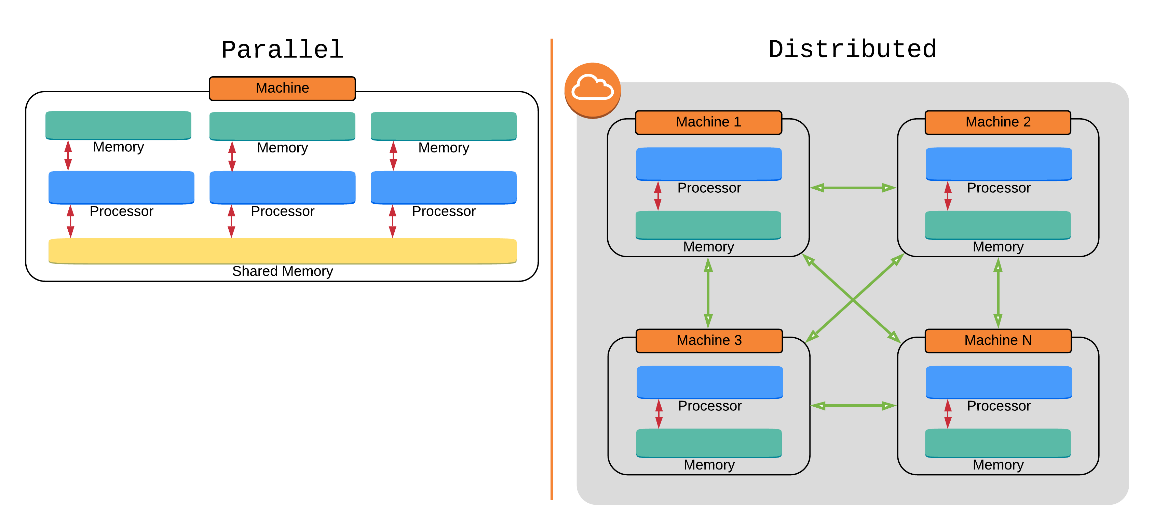
* [Image source](https://medium.com/@ManningBooks/explaining-mapreduce-with-ducks-f643c78e0b40)



* In a **distributed computing system**, each individual computer is often called a **node** and the collection of all of them is called a **cluster**
* A cluster alone is not powerful
* You need **processing engine**/**processing framework** to **coordinate work** across computers. 
* **Spark** is a processing framework: it manages and coordinates the execution of tasks on data across a cluster of computers.


## Spark Architecture

* **Spark Cluster**: treats many machines as one machine via a master-worker architecture
* **Driver**:
 * sits on a node in the cluster
 * analyses, distributes, and schedules work across the
executors.

 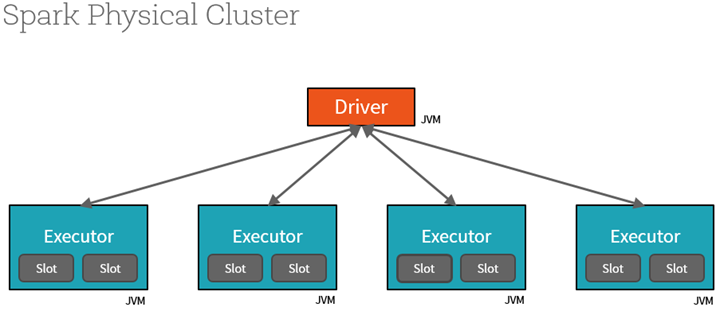

* The driver sends tasks to the empty slots on the **executors** when work has to be done:

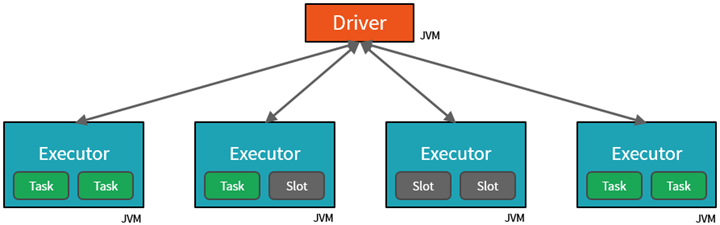

[Images' source](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/346304/2168141618055043/484361/latest.html)



# Creating a Spark session and reading some data

## Setup

In [ ]:
!pip install pyspark

In [ ]:
# Instructions on p. 20 Learning Spark, 2nd ed.
# 1) Install pyspark via conda/pip
#          pyspark requires the JAVA_HOME environment variable is set.
# 2) Install JRE/JDK, figure out the install location
#          You will need to install Java 8 or above
# 3) Update the JAVA_HOME environment variable set programmatically below 
#    with your installation specifics

# Some maybe helpful pointers on JRE/JDK:
# MacOS: Consider using https://github.com/AdoptOpenJDK/homebrew-openjdk
# Debian (colab): !apt install openjdk-8-jdk-headless -qq
# Windows: 
#    If you didn't change the path during installation, it'll be 
#    something like C:\Program Files\Java\jdk1.8.0_65
#    You can also type where java at the command prompt.

# JAVA_HOME environment variable is set programatically below
# but you must point it to your local install

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" # e.g. linux 
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/"

In [ ]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf

Let's initialise a **Spark Session**. 
* A SparkSession object is the entry point to the Spark functionality. 
* When you create the SparkSession object, it initiates a **Spark Application** which all the code for that Session will run on.


In [ ]:
# create the Spark session
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## Spark UI

* We can easily check the current version and get the link of the web interface, **Spark UI**. 
* In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

# Spark DataFrames


> Inspired by pandas DataFrames in structure, format, and a few specific operations,
Spark DataFrames are like distributed in-memory tables with named columns and
schemas, where each column has a specific data type: integer, string, array, map, real,
date, timestamp, etc. To a human’s eye, a Spark DataFrame is like a table

* Spark DataFrames Are **not** the same as pandas DataFrames. 
* Data is organized into named columns, like a table in a relational database.
* Accessing and manipulating data is similar to methods known from relational databases.
    * Knowing about pandas and spark gives you a solid background for understanding SQL which we'll cover later.

## Reading data into a DataFrame


Let's download [some data](https://courses.compute.dtu.dk/02807/2021/lectures/week7/titanic.csv) to work with. Observe that, unlike pandas, we can't directly specify a URL but need the `.csv` locally.

We specify that we want to interpret the first line as headers and that we want Spark to try to infer the types of the data.

In [ ]:
df = spark.read.option('header', True) \
                .option('inferSchema', True) \
                .csv('titanic.csv')

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## Showing the data

In [ ]:
# .head()
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [ ]:
df.toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,None,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,None,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,None,S


# DataFrame API

The DataFrame API is used to build queries, which Spark is responsible for realizing.

## Select

In [ ]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.select.html
# Takes *cols as argument, meaning an arbitrary argument list of spark.Column references
# https://docs.python.org/3.7/tutorial/controlflow.html#arbitrary-argument-lists

In [ ]:
df['Name'], F.col('Name'), F.col('abc')
# df['abc'] # fails: no column named abc in dataframe

(Column<b'Name'>, Column<b'Name'>, Column<b'abc'>)

In [ ]:
# 0, 1, 2 elements in *cols
df.select().show(3)
df.select(F.col('Name')).show(3, truncate=False)
df.select(F.col('Name'), F.col('Fare')).show(3, truncate=False)

++
||
++
||
||
||
++
only showing top 3 rows

+---------------------------------------------------+
|Name                                               |
+---------------------------------------------------+
|Braund, Mr. Owen Harris                            |
|Cumings, Mrs. John Bradley (Florence Briggs Thayer)|
|Heikkinen, Miss. Laina                             |
+---------------------------------------------------+
only showing top 3 rows

+---------------------------------------------------+-------+
|Name                                               |Fare   |
+---------------------------------------------------+-------+
|Braund, Mr. Owen Harris                            |7.25   |
|Cumings, Mrs. John Bradley (Florence Briggs Thayer)|71.2833|
|Heikkinen, Miss. Laina                             |7.925  |
+---------------------------------------------------+-------+
only showing top 3 rows



In [ ]:
# 2-tuple of spark Columns
columns = df['Name'], F.col('Fare')
# unpacking tuple using *; useful to modularize query
df.select(*columns).show(5)

+--------------------+-------+
|                Name|   Fare|
+--------------------+-------+
|Braund, Mr. Owen ...|   7.25|
|Cumings, Mrs. Joh...|71.2833|
|Heikkinen, Miss. ...|  7.925|
|Futrelle, Mrs. Ja...|   53.1|
|Allen, Mr. Willia...|   8.05|
+--------------------+-------+
only showing top 5 rows



## Limit, filter

In [ ]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [ ]:
pd.testing.assert_frame_equal(
    df.limit(3).toPandas(),
    df.toPandas().head(3)
)

* https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html?highlight=filter#pyspark.sql.DataFrame.filter
* Takes a Column of types.BooleanType or a string of SQL expression.

In [ ]:
print(F.col('survived') == True)
df.filter(F.col('survived') == True).limit(3).toPandas()

Column<b'(survived = true)'>


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [ ]:
# Comparison with Column produces a new column
# This used to form more complex conditionals
cond = F.col('survived') == True
print(cond)

cond_full = (cond) & \
            (F.col('Fare') > 70)
print(cond_full)

df.filter(cond).limit(3).toPandas()\
    .append(df.filter(cond_full).limit(3).toPandas())

Column<b'(survived = true)'>
Column<b'((survived = true) AND (Fare > 70))'>


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
2,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


## Sort

* In general, various combinations of spark types are used as input to spark operations
* Reading the docs requires this perspective when building API expressions
* `orderBy` is an alias for `sort`

In [ ]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sort.html
# DataFrame.sort(*cols, **kwargs)
df.sort(df['Name'], ascending=False).limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,None,S
1,112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,None,C
2,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S


In [ ]:
# Explicitly setting direction of sort using F (SQL functions), or 
# by using ascending keyword
sort_cols = F.desc('Survived'), F.asc('Name')

print(sort_cols)

pd.testing.assert_frame_equal(
    df.sort(*sort_cols).limit(3).toPandas(),
    df.sort(F.col('Survived'), F.col('Name'), ascending=[False, True]).limit(3).toPandas()
)

df.sort(*sort_cols).limit(3).toPandas()

(Column<b'Survived DESC NULLS LAST'>, Column<b'Name ASC NULLS FIRST'>)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,147,1,3,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",male,27.0,0,0,350043,7.7958,None,S
1,23,1,3,"""McGowan, Miss. Anna """"Annie""""""",female,15.0,0,0,330923,8.0292,None,Q
2,29,1,3,"""O'Dwyer, Miss. Ellen """"Nellie""""""",female,NaN,0,0,330959,7.8792,None,Q


## Adding columns

In the titanic dataset, we have the following columns:

* ``sibsp``: Number of Siblings/Spouses Aboard
* ``parch``: Number of Parents/Children Aboard

A passenger's fare is not the price of each passenger, but the price of each ticket, which is bought for the entire family. We can calculate the fare per passenger by spreading the cost amongst the family members. 

In [ ]:
# Also a spark.Column object
person_fare = F.col('Fare') / (F.col('SibSp') + F.col('Parch') + 1)

# select accepts strings as well
df.withColumn('PersonFare', person_fare) \
    .select('SibSp', 'Parch', 'Fare', 'PersonFare') \
    .show(10)

+-----+-----+-------+----------+
|SibSp|Parch|   Fare|PersonFare|
+-----+-----+-------+----------+
|    1|    0|   7.25|     3.625|
|    1|    0|71.2833|  35.64165|
|    0|    0|  7.925|     7.925|
|    1|    0|   53.1|     26.55|
|    0|    0|   8.05|      8.05|
|    0|    0| 8.4583|    8.4583|
|    0|    0|51.8625|   51.8625|
|    3|    1| 21.075|     4.215|
|    0|    2|11.1333|    3.7111|
|    1|    0|30.0708|   15.0354|
+-----+-----+-------+----------+
only showing top 10 rows



## Removing columns

In [ ]:
drop_id_df = df.drop('PassengerId')

In [ ]:
drop_id_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [ ]:
drop_id_df.show(3)

+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 3 rows



## User-defined functions (Self-study)
* If you want to apply your own function to a column you need to register it as a user-defined function (UDF). 

* UDFs can be used in a number of ways: using `select()`, `withColumn()`, `filter()`, etc.

Let's create a function that extracts the title of the passenger. Names are in the form `Lastname, Title. Firstname`.

In [ ]:
def extract_title(name):
    name_parts = name.split(',')
    title_and_first = name_parts[1].split('.')
    return title_and_first[0]

extract_title_udf = F.udf(extract_title)

In [ ]:
df.withColumn('Title', extract_title_udf(F.col('Name'))).select('Name', 'Title').show()

+--------------------+-------+
|                Name|  Title|
+--------------------+-------+
|Braund, Mr. Owen ...|     Mr|
|Cumings, Mrs. Joh...|    Mrs|
|Heikkinen, Miss. ...|   Miss|
|Futrelle, Mrs. Ja...|    Mrs|
|Allen, Mr. Willia...|     Mr|
|    Moran, Mr. James|     Mr|
|McCarthy, Mr. Tim...|     Mr|
|Palsson, Master. ...| Master|
|Johnson, Mrs. Osc...|    Mrs|
|Nasser, Mrs. Nich...|    Mrs|
|Sandstrom, Miss. ...|   Miss|
|Bonnell, Miss. El...|   Miss|
|Saundercock, Mr. ...|     Mr|
|Andersson, Mr. An...|     Mr|
|Vestrom, Miss. Hu...|   Miss|
|Hewlett, Mrs. (Ma...|    Mrs|
|Rice, Master. Eugene| Master|
|Williams, Mr. Cha...|     Mr|
|Vander Planke, Mr...|    Mrs|
|Masselmani, Mrs. ...|    Mrs|
+--------------------+-------+
only showing top 20 rows



## Aggregate functions and summary statistics (Self-study)
We can also group values and compute statistics.

Functions:

- ``avg()``
- ``count()``
- ``max()``
- ``min()``
- ``sum()``

In [ ]:
# Total fare
df.select(F.sum('Fare')).show()

+-----------------+
|        sum(Fare)|
+-----------------+
|4385.095600000001|
+-----------------+



In [ ]:
# Total, average, max and min
df.select(F.sum('Fare'), F.avg('Fare'), F.max('Fare'), F.min('Fare')).show()

+-----------------+------------------+---------+---------+
|        sum(Fare)|         avg(Fare)|max(Fare)|min(Fare)|
+-----------------+------------------+---------+---------+
|4385.095600000001|28.109587179487182|    263.0|     6.75|
+-----------------+------------------+---------+---------+



In [ ]:
# filter out lower-fare entries
df.filter(F.col('Fare') > 15) \
    .select(F.sum('Fare'), F.avg('Fare'), F.max('Fare'), F.min('Fare')) \
    .show()

+------------------+-----------------+---------+---------+
|         sum(Fare)|        avg(Fare)|max(Fare)|min(Fare)|
+------------------+-----------------+---------+---------+
|3642.1246999999985|49.21790135135133|    263.0|  15.0458|
+------------------+-----------------+---------+---------+



The ``.describe()`` method produces summary statistics on columns of our choosing.

In [ ]:
df.describe('Age', 'Fare').show()

+-------+------------------+------------------+
|summary|               Age|              Fare|
+-------+------------------+------------------+
|  count|               126|               156|
|   mean|28.141507936507935|28.109587179487182|
| stddev| 14.61387992656079|  39.4010466964926|
|    min|              0.83|              6.75|
|    max|              71.0|             263.0|
+-------+------------------+------------------+



You can also group data in a column and compute aggregates per group.

In [ ]:
# Total per passenger class
df.groupBy('Pclass').agg(F.avg('Fare')).orderBy('avg(Fare)', ascending=False).show()

+------+------------------+
|Pclass|         avg(Fare)|
+------+------------------+
|     1| 79.50193999999998|
|     2|23.659719999999997|
|     3|13.440060416666663|
+------+------------------+



## Data from driver to spark (Self-study)

* It may sometimes be convenient to populate a DataFrame programatically as done here.

In [ ]:
from pyspark.sql import SQLContext

first_values = range(500000)
second_values = range(500000)
values = zip(first_values, second_values)
df_ranges = SQLContext(sc).createDataFrame(values, ['val1', 'val2'])

df_ranges.count(), df_ranges.schema

(500000,
 StructType(List(StructField(val1,LongType,true),StructField(val2,LongType,true))))

In [ ]:
df_ranges.select((F.col('val1') + F.col('val2')).alias('val_sum')).toPandas().head(5)

DataFrame[val_sum: bigint]

# Spark operations: Transformations vs actions

Two functions so far have been used to materialize the data: `toPandas()` and `show()`. The remaining functions are evaluated lazily.

> Lazy evaluation is Spark’s strategy for delaying execution until an action is invoked or data is “touched” (read from or written to disk).

> An action triggers the lazy evaluation of all the recorded transformations.

The operations you can do within a Spark application are divided into two types:

**Transformations**: 
* When applied to a (Spark) DataFrame, they return a new DataFrame created via the transformation. Examples:
    * `select`, `limit`: returns a subset of a DataFrame
    * ``filter``: returns an DataFrame with those elements that pass a condition.
    * ``sort``: returns a sorted DataFrame.
    * `groupBy`, `join`
* Transformations are **LAZY**
* Instead of running the transformations one by one as soon as it receives them, Spark stores these transformations in a Directed Acyclic Graph (DAG)

**Actions**: 

* When applied to an DataFrame, they materialize your DataFrame API query. Examples: 
    * `show()`, `toPandas()`, 
    * `count`: returns the number of rows in DataFrame to the Spark driver (`count` is a transformation when applied to a GroupedDataset).  
    * ``collect``: sends the contents of a DataFrame to the driver.
* Actions are **EAGER**
* As soon as it receives an action, sparks runs the whole DAG (all the transformations specified) and delivers the requested output.


# Spark under the hood

The DataFrame API is a recipe for how our data is to be processed. Spark is responsible for making this reality in a distributed setting. It requires knowledge of how Spark is able to do so, in order to write performant queries.

## RDDs: the basic data structure in Spark

RDD = Resilient Distributed Datasets

* **Resilient**: i.e. **fault-tolerant** with the help of **immutability** and the **RDD lineage graph** (ensures that we can recompute missing or damaged partitions due to node failures).
 * **Immutability**: once an RDD has been created, it is impossible to alter it.
 * **Lineage graph**: keeps track of where an RDD comes from.
 ![Lineage graph](https://2.bp.blogspot.com/-7z9pTkw0EBs/Wn4ocfDTmII/AAAAAAAAEHM/yobSB13veOwwoIR2loy0p2wm-bF6miEqgCLcBGAs/s1600/RDDLineage.JPG)

* **Distributed**: data is partitioned and distributed across multiple nodes
* **Dataset**: collection of partitioned data


## DataFrames are performant

* Has all of the features of RDDs (e.g. resiliency).
* Optimisations and performance improvements: Catalyst optimisation and JVM bytecode for execution.
* https://databricks.com/blog/2015/02/17/introducing-dataframes-in-spark-for-large-scale-data-science.html

![RDD vs DataFrames](https://databricks.com/wp-content/uploads/2015/02/Screen-Shot-2015-02-16-at-9.46.39-AM.png)

Image source: Databricks

## Lazy evaluation and Catalyst optimisation

* Most importantly, lazy evaluation over DataFrames allows Spark to automatically apply various optimisations

*  Spark's **Catalyst** optimiser is responsible for this. For more information, read [this blog!](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html)
  
![Catalyst](https://files.training.databricks.com/images/105/catalyst-diagram.png)

[Image source](https://files.training.databricks.com/images/105/catalyst-diagram.png)

## Spark Jobs

* When you invoke an action, a **job** is created. Jobs are work submitted to Spark.
* A job will then be decomposed into single or multiple **stages**
* Each stage is divided into individual **tasks** that can be run simultaneously. 
* A **task** is a single unit of work that the Spark driver ships to an executor for completion.
* It is Spark's ability to generate distributed data processing jobs, that allows it to scale to massive amounts of data.
    * In this course, we'll only be using it on a local machine where the scaling benefits are **limited**.

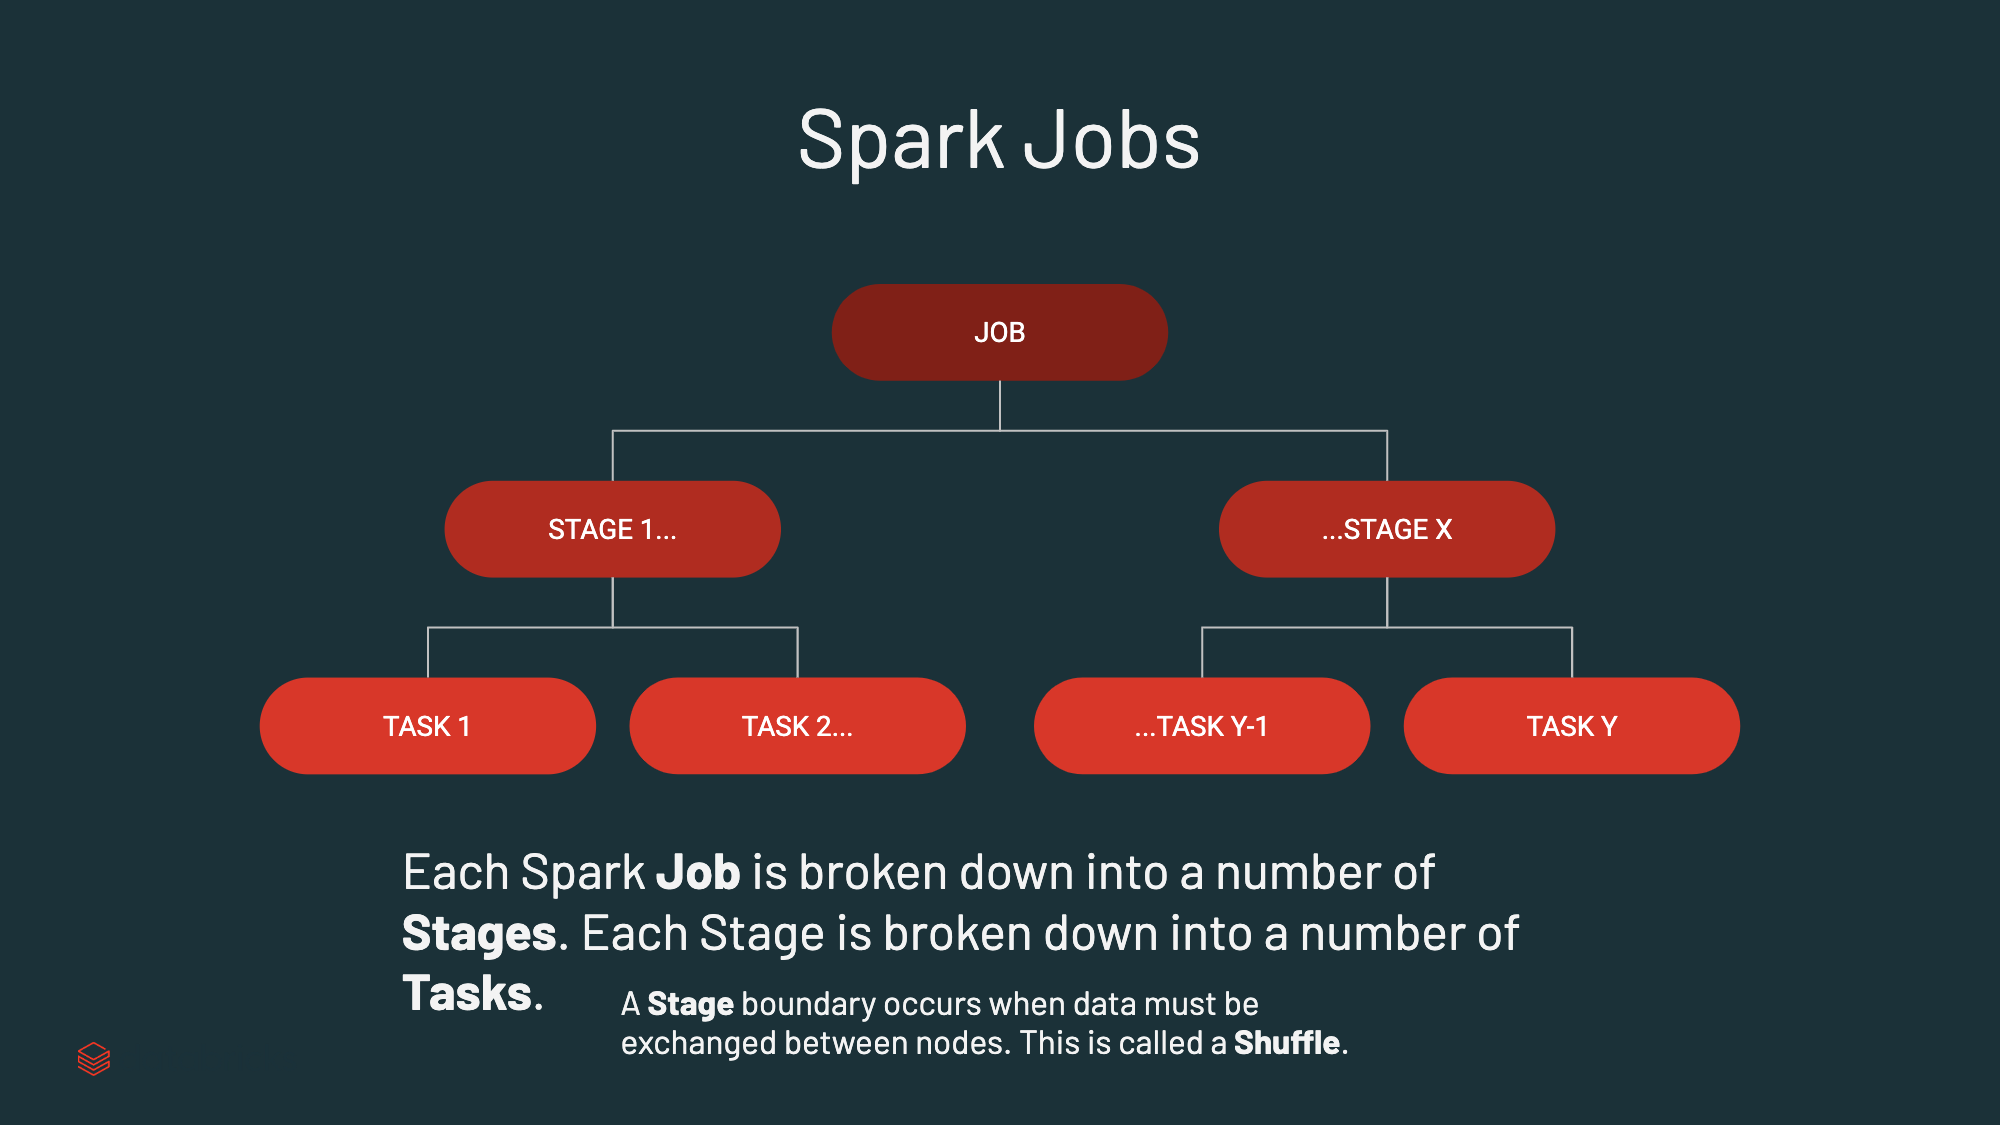


[Image source](https://github.com/databricks/tech-talks/blob/master/2020-04-29%20%7C%20Intro%20to%20Apache%20Spark/Intro%20to%20Spark.pdf)

# Narrow and wide transformations

* **Narrow transformation**: 
 * when applied on an RDD, there is no data movement between partitions. 
 * each partition of the parent RDD is used by at most one partition of the child RDD
 * example: ``filter``, ``union``


* **Wide transformation**:
 * requires data movement between partitions, which is known as **shuffle** (or exchange), leads to a stage boundary. 
 * the data is moved across the network and the partitions of the newly-created RDD are based on the data of multiple input partitions.
 * example: ``sort``, `groupby`, ``count``


## `filter`: narrow transformation

* Let's view Spark UI > SQL: We identify latest query as the one invoked via jupyter
* Filtering is a narrow transformation: It can take place on each data partition

In [ ]:
# This Spark DataFrame is modified under the hood, but not yet materialized
filtered_df = df.filter(F.col('survived') == True).filter(F.col('Cabin').isNotNull())

# collect is an action
filtered_df.collect()

[Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C'),
 Row(PassengerId=4, Survived=1, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Age=35.0, SibSp=1, Parch=0, Ticket='113803', Fare=53.1, Cabin='C123', Embarked='S'),
 Row(PassengerId=11, Survived=1, Pclass=3, Name='Sandstrom, Miss. Marguerite Rut', Sex='female', Age=4.0, SibSp=1, Parch=1, Ticket='PP 9549', Fare=16.7, Cabin='G6', Embarked='S'),
 Row(PassengerId=12, Survived=1, Pclass=1, Name='Bonnell, Miss. Elizabeth', Sex='female', Age=58.0, SibSp=0, Parch=0, Ticket='113783', Fare=26.55, Cabin='C103', Embarked='S'),
 Row(PassengerId=22, Survived=1, Pclass=2, Name='Beesley, Mr. Lawrence', Sex='male', Age=34.0, SibSp=0, Parch=0, Ticket='248698', Fare=13.0, Cabin='D56', Embarked='S'),
 Row(PassengerId=24, Survived=1, Pclass=1, Name='Sloper, Mr. William Thompso

In [ ]:
filtered_df.explain(True)

== Physical Plan ==
*(1) Project [PassengerId#16, Survived#17, Pclass#18, Name#19, Sex#20, Age#21, SibSp#22, Parch#23, Ticket#24, Fare#25, Cabin#26, Embarked#27]
+- *(1) Filter ((isnotnull(survived#17) AND (survived#17 = 1)) AND isnotnull(Cabin#26))
   +- FileScan csv [PassengerId#16,Survived#17,Pclass#18,Name#19,Sex#20,Age#21,SibSp#22,Parch#23,Ticket#24,Fare#25,Cabin#26,Embarked#27] Batched: false, DataFilters: [isnotnull(Survived#17), (Survived#17 = 1), isnotnull(Cabin#26)], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Survived), EqualTo(Survived,1), IsNotNull(Cabin)], ReadSchema: struct<PassengerId:int,Survived:int,Pclass:int,Name:string,Sex:string,Age:double,SibSp:int,Parch:...




In [ ]:
# show is an action
# same structure as collect, except string casts and limit viz. SparkUI
filtered_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----+--------+
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|PC 17599|71.2833|  C85|       C|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|  113803|   53.1| C123|       S|
|         11|       1|     3|Sandstrom, Miss. ...|female| 4.0|    1|    1| PP 9549|   16.7|   G6|       S|
|         12|       1|     1|Bonnell, Miss. El...|female|58.0|    0|    0|  113783|  26.55| C103|       S|
|         22|       1|     2|Beesley, Mr. Lawr...|  male|34.0|    0|    0|  248698|   13.0|  D56|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----+--------+
only showing top 5 rows



## Catalyst optimization of queries

* Observe that in the physical plan for the query below, the order of filter and sort is swapped. 
* This is known as predicate pushdown (conditions are predicated): The filter can take place "locally", then sorting happens on a subset of the data. It is allowed, as the final result will be the same.
* Pandas API unable to perform such optimizations.

In [ ]:
df.sort(df['Name'].desc()) \
    .filter(F.col('survived') == True) \
    .explain()

== Physical Plan ==
*(2) Sort [Name#19 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(Name#19 DESC NULLS LAST, 200), true, [id=#475]
   +- *(1) Project [PassengerId#16, Survived#17, Pclass#18, Name#19, Sex#20, Age#21, SibSp#22, Parch#23, Ticket#24, Fare#25, Cabin#26, Embarked#27]
      +- *(1) Filter (isnotnull(survived#17) AND (survived#17 = 1))
         +- FileScan csv [PassengerId#16,Survived#17,Pclass#18,Name#19,Sex#20,Age#21,SibSp#22,Parch#23,Ticket#24,Fare#25,Cabin#26,Embarked#27] Batched: false, DataFilters: [isnotnull(Survived#17), (Survived#17 = 1)], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Survived), EqualTo(Survived,1)], ReadSchema: struct<PassengerId:int,Survived:int,Pclass:int,Name:string,Sex:string,Age:double,SibSp:int,Parch:...




* This query gives the same physical plan as above.
* Both predicate pushdown used and removal of irrelevant Pclass sorting.

In [ ]:
df.sort(df['Pclass'].desc()) \
    .filter(F.col('survived') == True) \
    .sort(df['Name'].desc()) \
    .explain()

== Physical Plan ==
*(2) Sort [Name#19 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(Name#19 DESC NULLS LAST, 200), true, [id=#496]
   +- *(1) Project [PassengerId#16, Survived#17, Pclass#18, Name#19, Sex#20, Age#21, SibSp#22, Parch#23, Ticket#24, Fare#25, Cabin#26, Embarked#27]
      +- *(1) Filter (isnotnull(survived#17) AND (survived#17 = 1))
         +- FileScan csv [PassengerId#16,Survived#17,Pclass#18,Name#19,Sex#20,Age#21,SibSp#22,Parch#23,Ticket#24,Fare#25,Cabin#26,Embarked#27] Batched: false, DataFilters: [isnotnull(Survived#17), (Survived#17 = 1)], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Survived), EqualTo(Survived,1)], ReadSchema: struct<PassengerId:int,Survived:int,Pclass:int,Name:string,Sex:string,Age:double,SibSp:int,Parch:...




* Let's look at this query containing a wide transformation, and its related jobs, in the Spark UI

In [ ]:
df.sort(df['Pclass'].desc()) \
    .filter(F.col('survived') == True) \
    .sort(df['Name'].desc()) \
    .collect()

[Row(PassengerId=56, Survived=1, Pclass=1, Name='Woolner, Mr. Hugh', Sex='male', Age=None, SibSp=0, Parch=0, Ticket='19947', Fare=35.5, Cabin='C52', Embarked='S'),
 Row(PassengerId=18, Survived=1, Pclass=2, Name='Williams, Mr. Charles Eugene', Sex='male', Age=None, SibSp=0, Parch=0, Ticket='244373', Fare=13.0, Cabin=None, Embarked='S'),
 Row(PassengerId=59, Survived=1, Pclass=2, Name='West, Miss. Constance Mirium', Sex='female', Age=5.0, SibSp=1, Parch=2, Ticket='C.A. 34651', Fare=27.75, Cabin=None, Embarked='S'),
 Row(PassengerId=134, Survived=1, Pclass=2, Name='Weisz, Mrs. Leopold (Mathilde Francoise Pede)', Sex='female', Age=29.0, SibSp=1, Parch=0, Ticket='228414', Fare=26.0, Cabin=None, Embarked='S'),
 Row(PassengerId=124, Survived=1, Pclass=2, Name='Webber, Miss. Susan', Sex='female', Age=32.5, SibSp=0, Parch=0, Ticket='27267', Fare=13.0, Cabin='E101', Embarked='S'),
 Row(PassengerId=32, Survived=1, Pclass=1, Name='Spencer, Mrs. William Augustus (Marie Eugenie)', Sex='female', Age

# Wide transformations and actions in a distributed setting

* Let's investigate how spark achieves it's distributed data processing.

## `sort`: Wide transformation

Sort is a wide transformation, but when we investigate Spark UI it still takes place in a distributed manner (i.e. we spawn hundreds of tasks in the second stage). How is this possible?

> Sorting in Spark is a multiphase process which requires shuffling (exchange):
> * input RDD is sampled and this sample is used to compute boundaries for each output partition (sample followed by collect)
> * input RDD is partitioned using rangePartitioner with boundaries computed in the first step (partitionBy)
> * each partition from the second step is sorted locally (mapPartitions)

> When the data is collected, all that is left is to follow the order defined by the partitioner.
> [Source](https://stackoverflow.com/questions/32887595/how-does-spark-achieve-sort-order/32888236#32888236)

In [ ]:
# sort is a wide transformation
# it leads to an Exchange step (a shuffle)
df.sort(F.col('Name')).explain()

== Physical Plan ==
*(1) Sort [Name#19 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(Name#19 ASC NULLS FIRST, 200), true, [id=#528]
   +- FileScan csv [PassengerId#16,Survived#17,Pclass#18,Name#19,Sex#20,Age#21,SibSp#22,Parch#23,Ticket#24,Fare#25,Cabin#26,Embarked#27] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<PassengerId:int,Survived:int,Pclass:int,Name:string,Sex:string,Age:double,SibSp:int,Parch:...




## Count leads to a stage boundary

Count is an action or a wide transformation depending on context. In both cases it triggers stage boundaries.
* **Stage 1**: each task counts its own partition of the data
* **Stage 2**: data is exchanged (shuffled) to compute the aggregate
    * The second stage involves an exchange (shuffle), which leads to a stage boundary.
    * How the data is exchanged depends on context.
* We can  use the Spark UI to look at the anatomy of the job triggered by the count action.
* Spark UI offers a DAG visualisation of jobs ([How to read Spark job DAGs](https://dzone.com/articles/reading-spark-dags))

In [ ]:
# An action, applied to a dataframe
# Exchange is SinglePartition
df.count()

156

In [ ]:
# Exchange is still SinglePartition, more tasks spawned due to data size
df_ranges.count()

500000

In [ ]:
# groupby is a wide transformation
# This count is a wide transformation
# Exchange is via hashpartioning: Gathers up records of same Pclass value on same worker
df.groupby(F.col('Pclass')).count().show()

+------+-----+
|Pclass|count|
+------+-----+
|     1|   30|
|     3|   96|
|     2|   30|
+------+-----+



In [ ]:
df.groupby(F.col('Pclass')).count().explain()

== Physical Plan ==
*(2) HashAggregate(keys=[Pclass#18], functions=[count(1)])
+- Exchange hashpartitioning(Pclass#18, 200), true, [id=#780]
   +- *(1) HashAggregate(keys=[Pclass#18], functions=[partial_count(1)])
      +- FileScan csv [Pclass#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Pclass:int>




## Stage boundaries in a word count

* The `groupby`/`count` above takes place in a manner similar to the case where we want to count words in text.
* Edges cross over indicates an exchange/shuffle
* Final step is caused by e.g. `collect` and runs on the driver

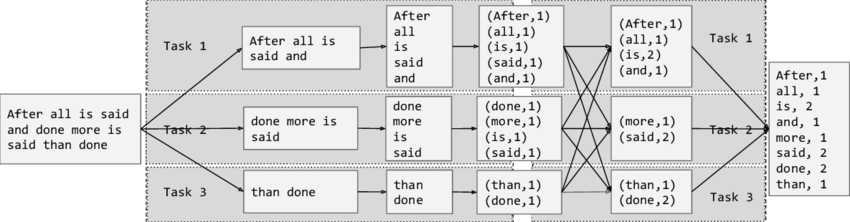

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([StructField('line', StringType(), True)])
line = 'After all is said and done more is said than done'

df_saying = SQLContext(sc).createDataFrame([{'line': line}], schema)
df_saying.show()

+--------------------+
|                line|
+--------------------+
|After all is said...|
+--------------------+



In [ ]:
df_saying_words = df_saying \
    .select(F.explode(F.split(F.col('line'), ' ')).alias('word')) \

df_saying_words.toPandas()

,word
0,After
1,all
2,is
3,said
4,and
5,done
6,more
7,is
8,said
9,than


In [ ]:
df_saying_words_counted = df_saying_words.groupby('word').count()
df_saying_words_counted.explain()

== Physical Plan ==
*(3) HashAggregate(keys=[word#946], functions=[count(1)])
+- Exchange hashpartitioning(word#946, 200), true, [id=#654]
   +- *(2) HashAggregate(keys=[word#946], functions=[partial_count(1)])
      +- Generate explode(split(line#938,  , -1)), false, [word#946]
         +- *(1) Scan ExistingRDD[line#938]




In [ ]:
df_saying_words_counted.collect()

[Row(word='more', count=1),
 Row(word='than', count=1),
 Row(word='After', count=1),
 Row(word='is', count=2),
 Row(word='done', count=2),
 Row(word='said', count=2),
 Row(word='and', count=1),
 Row(word='all', count=1)]

In [ ]:
words = F.explode(F.split(F.col('Name'), ' ')).alias('word'), F.col('Fare')

# filter is a narrow transformation
# count is a wide transformation as it is applied to GroupedDataset
# sort is a wide transformation
query_multiple_boundaries = df.select(*words) \
    .filter(F.col('Fare') > 10) \
    .groupby('word') \
    .count() \
    .sort(F.desc('count'))

query_multiple_boundaries.explain()

== Physical Plan ==
*(4) Sort [count#962L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(count#962L DESC NULLS LAST, 200), true, [id=#697]
   +- *(3) HashAggregate(keys=[word#956], functions=[count(1)])
      +- Exchange hashpartitioning(word#956, 200), true, [id=#693]
         +- *(2) HashAggregate(keys=[word#956], functions=[partial_count(1)])
            +- Generate explode(split(Name#19,  , -1)), false, [word#956]
               +- *(1) Project [Name#19]
                  +- *(1) Filter (isnotnull(Fare#25) AND (Fare#25 > 10.0))
                     +- FileScan csv [Name#19,Fare#25] Batched: false, DataFilters: [isnotnull(Fare#25), (Fare#25 > 10.0)], Format: CSV, Location: InMemoryFileIndex[file:/Users/martinholmjensen/dtu/courses/02807/week7/titanic.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Fare), GreaterThan(Fare,10.0)], ReadSchema: struct<Name:string,Fare:double>




In [ ]:
query_multiple_boundaries.collect()

[Row(word='Mr.', count=43),
 Row(word='Miss.', count=21),
 Row(word='Mrs.', count=20),
 Row(word='Master.', count=8),
 Row(word='William', count=7),
 Row(word='Charles', count=4),
 Row(word='John', count=4),
 Row(word='Joseph', count=4),
 Row(word='Alexander', count=3),
 Row(word='Maria', count=3),
 Row(word='Robert', count=3),
 Row(word='James', count=2),
 Row(word='Turpin,', count=2),
 Row(word='Rev.', count=2),
 Row(word='Planke,', count=2),
 Row(word='Andersson,', count=2),
 Row(word='Helen', count=2),
 Row(word='Palsson,', count=2),
 Row(word='M', count=2),
 Row(word='Anna', count=2),
 Row(word='Nasser,', count=2),
 Row(word='Goodwin,', count=2),
 Row(word='Williams,', count=2),
 Row(word='Futrelle,', count=2),
 Row(word='Heath', count=2),
 Row(word='J', count=2),
 Row(word='Anne', count=2),
 Row(word='Nicholas', count=2),
 Row(word='A', count=2),
 Row(word='Samuel', count=2),
 Row(word='Jacques', count=2),
 Row(word='Oscar', count=2),
 Row(word='Bertha', count=2),
 Row(word='Augu

# Take-aways

* Spark is a framework for distributed computing. 
* Distributed computing allows us to scale data processing beyond what any single machine can compute in reasonable amounts of time.
    * Requires us to understand how the driver interacts with the spark architecture.
* Spark's DataFrame API is based on SQL-like constructs. 
    * Queries in spark are achieved by transformations (narrow or wide) and actions.
    * Queries are automatically optimized on multiple levels; e.g. predicate pushdown and expressions as java bytecode.
* Wide transformations and some actions require data shuffle/exchange
    * Typically expensive operations as I/O is involved.
    * Allows for data processing of dependent data to occur distributed.
* Investigating Spark's query planning and jobs/tasks informs us how data processing is achieved.